In [166]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.modeling import models, fitting
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import stats
import photutils
import math
import astroalign as asa


In [3]:
magnitude = 7.2
C = 299792458*10**10 #in Angstrom
lamb = 5500 #in Angstrom

In [4]:
f_freq = 3631*10**(-23)*10**(-magnitude/2.5)
f_lambda = f_freq*C/lamb**2
f_lambda #erg/A*s*cm2

4.743747592735647e-12

In [5]:
calibration = 15.28
#electrons per second on each pixel
print("estimated count per second:",10**calibration * f_lambda)

estimated count per second: 9039.024693890478


In [6]:
#Example of how to open a file
bias0 = fits.open("./dataM103/bias_000bias.fit")
print(bias0.info(),'\n'*2)
print(bias0[0].data)


Filename: ./dataM103/bias_000bias.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (4499, 3599)   int16 (rescales to uint16)   
None 


[[343 407 383 ... 343 375 388]
 [362 373 388 ... 340 363 411]
 [346 355 351 ... 403 379 392]
 ...
 [382 358 397 ... 478 445 462]
 [378 352 355 ... 415 401 490]
 [381 407 402 ... 402 467 433]]


# Bias

In [7]:
files_bias = glob.glob("./dataM103/*bias*.fit")

In [8]:
#plt.imshow(bias0[0].data,vmin=0,vmax=100)

In [9]:
def stacking(files,normalize=False,unbias=False):
    allpic=[]
    npic=0
    for ii, bb in enumerate(files) :
        mypic=fits.open(bb)
        allpic.append(mypic[0].data)
        mypic.close()
        npic+=1
    allpic=np.array(allpic)
    #print('Shape of stack', allpic.shape)
    meanval=np.mean(allpic, axis=0)
    if type(unbias) == np.ndarray:
        meanval = meanval - unbias
    if normalize:
        meanval = meanval/(np.mean(meanval))
    #print("Shape of array", meanval.shape)
    return meanval
    
meanbias = stacking(files_bias)
plt.clf()


<Figure size 640x480 with 0 Axes>

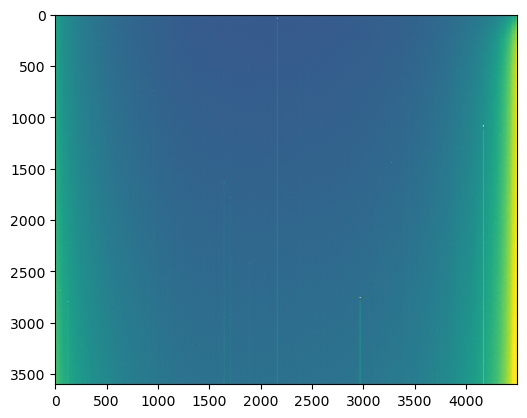

In [10]:
plt.imshow(meanbias,clim=[300,400])

In [11]:
# plt.hist(meanbias.flatten(),bins=30,density=False,log=True)

# Flat

In [12]:
files_flat_Ha = glob.glob("./dataM103/*flat*Ha.fit")
files_flat_OIII = glob.glob("./dataM103/*flat*OIII.fit")
files_flat_SII = glob.glob("./dataM103/*flat*SII.fit")

In [13]:
mean_flat_Ha = stacking(files_flat_Ha,unbias=meanbias,normalize=True)

In [14]:
#plt.hist(mean_flat_Ha.flatten(),bins=10,density=True,log=True)

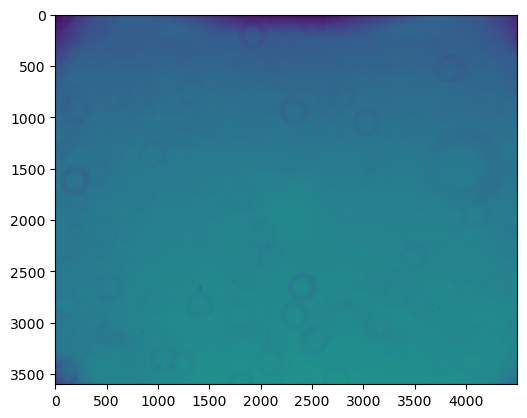

In [15]:
plt.imshow(mean_flat_Ha,clim=[0.8,1.3])

In [16]:
mean_flat_OIII = stacking(files_flat_OIII,unbias=meanbias,normalize=True)

In [17]:
# plt.hist(mean_flat_OIII.flatten(),bins=10,density=True,log=True)

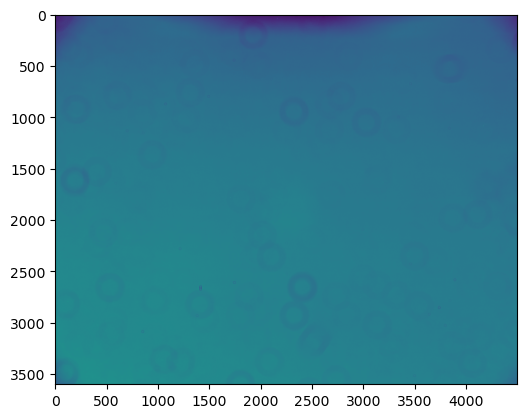

In [18]:
plt.imshow(mean_flat_OIII,clim=[0.8,1.3])

In [19]:
mean_flat_SII = stacking(files_flat_SII,unbias=meanbias,normalize=True)

In [20]:
# plt.hist(mean_flat_SII.flatten(),bins=10,density=True,log=True)

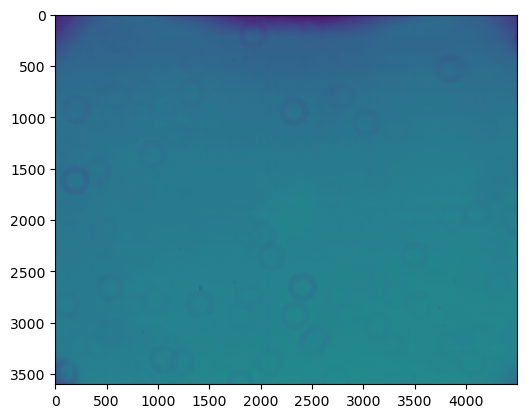

In [21]:
plt.imshow(mean_flat_SII,clim=[0.8,1.3])

# Data

In [22]:
data0 = fits.open("./dataM103/FSR0581_000Ha.fit")


In [23]:
data_files = glob.glob("./dataM103/M103*.fit")
calib_star = glob.glob("./dataM103/HD3360*.fit")

In [24]:
processed_images={}
for f in data_files:
    data = fits.open(f)
    if "Ha" in f:
        flat_data=mean_flat_Ha
    elif "OIII" in f:
        flat_data=mean_flat_OIII
    elif "SII" in f:
        flat_data=mean_flat_SII
    else:
        print('Cannot find filter type in image title')
    proc = (data[0].data-meanbias)/flat_data
    data.close()
    processed_images[f.split('/')[-1]]=proc*0.6

In [25]:
processed_calibration={}
for ca in calib_star:
    data = fits.open(ca)
    if "Ha" in ca:
        flat_data=mean_flat_Ha
    elif "OIII" in ca:
        flat_data=mean_flat_OIII
    elif "SII" in ca:
        flat_data=mean_flat_SII
    else:
        print('Cannot find filter type in image title')
    proc = (data[0].data-meanbias)/flat_data
    data.close()
    processed_calibration[ca.split('/')[-1]]=proc*0.6

In [26]:
processed_calibration.keys()

dict_keys(['HD3360_003Ha.fit', 'HD3360_003OIII.fit', 'HD3360_001Ha.fit', 'HD3360_002OIII.fit', 'HD3360_003SII.fit', 'HD3360_002Ha.fit', 'HD3360_001OIII.fit', 'HD3360_001SII.fit', 'HD3360_002SII.fit'])

In [27]:
processed_images.keys()

dict_keys(['M103_003OIII300s.fit', 'M103_003Ha300s.fit', 'M103_002Ha300s.fit', 'M103_002SII300s.fit', 'M103_004Ha300s.fit', 'M103_001SII300s.fit', 'M103_001Ha300s.fit', 'M103_002OIII300s.fit', 'M103_004SII300s.fit', 'M103_003SII300s.fit', 'M103_001OIII300s.fit', 'M103_004OIII300s.fit'])

## Dust on filters?

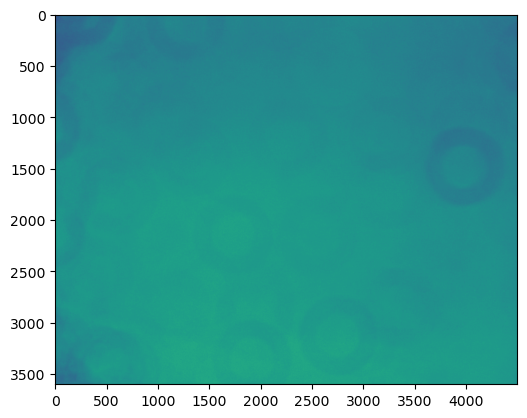

In [28]:
#Difference between filters
plt.imshow(mean_flat_Ha/mean_flat_SII,clim=[0.9,1.1])

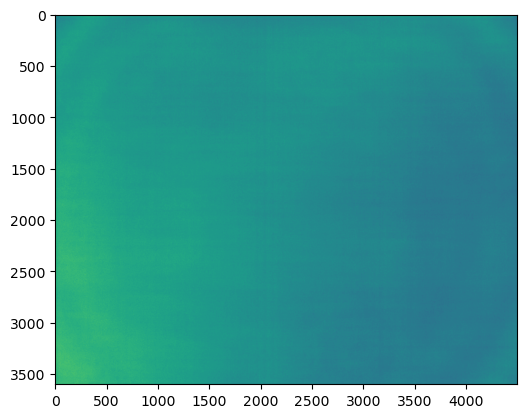

In [29]:
plt.imshow(mean_flat_OIII/mean_flat_SII,clim=[0.9,1.1])

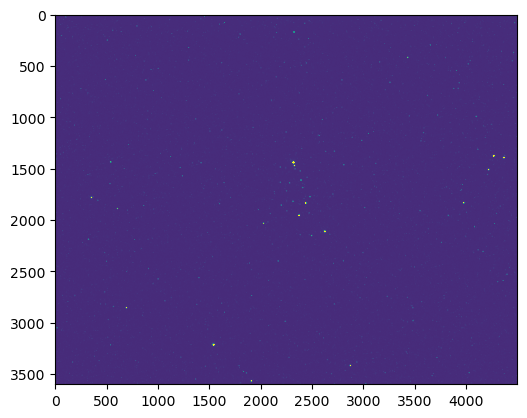

In [30]:
plt.imshow(processed_images['M103_003OIII300s.fit'],clim=[0,1000])

# Dark current

In [31]:
dark_files = glob.glob("./dataM103/*dark*.fit")

In [32]:
dark_files

['./dataM103/calib_044dark120.fit',
 './dataM103/calib_037dark60.fit',
 './dataM103/dark_008_60s.fit',
 './dataM103/dark_013_10s.fit',
 './dataM103/dark_003_10s.fit',
 './dataM103/dark_000_1s.fit',
 './dataM103/dark_012_1s.fit',
 './dataM103/dark_001_60s.fit',
 './dataM103/dark_011_60s.fit',
 './dataM103/calib_040dark60.fit',
 './dataM103/calib_037dark120.fit',
 './dataM103/dark_010_1s.fit',
 './dataM103/dark_002_1s.fit',
 './dataM103/dark_010_60s.fit',
 './dataM103/dark_000_60s.fit',
 './dataM103/calib_041dark120.fit',
 './dataM103/calib_046dark60.fit',
 './dataM103/dark_009_60s.fit',
 './dataM103/dark_002_10s.fit',
 './dataM103/dark_012_10s.fit',
 './dataM103/calib_038dark120.fit',
 './dataM103/dark_006_1s.fit',
 './dataM103/dark_014_1s.fit',
 './dataM103/dark_009_10s.fit',
 './dataM103/calib_036dark60.fit',
 './dataM103/dark_002_60s.fit',
 './dataM103/dark_012_60s.fit',
 './dataM103/calib_046dark120.fit',
 './dataM103/calib_035dark120.fit',
 './dataM103/dark_010_10s.fit',
 './dataM1

In [33]:
darkdict = {}
for dark in dark_files:
    data = fits.open(dark)
    expo = data[0].header['EXPTIME']
    darkdict.setdefault(expo, [])
    darkdict[expo].append(dark)
    data.close()

In [34]:
darkdict.keys()

dict_keys([120.0, 60.0, 10.0, 1.0])

In [35]:
dark_stacked = {}
for espos in darkdict.keys():
    dark_stacked[espos] = stacking(darkdict[espos],unbias=meanbias)*0.6

In [36]:
dark_stacked[120].shape

(3599, 4499)

## Dark Current Averaged

A single dark current is calculated for the whole sensor regardless pixel position

In [37]:
slope, intercept, r, p, std_err = stats.linregress(list(dark_stacked.keys()), [dark_stacked[i].mean() for i in dark_stacked.keys()])
print("Slope:",slope)
print("Intercept:",intercept)
print("R:",r)
print("P:",p)
print("Std_err:",std_err)

Slope: 0.040256695242345465
Intercept: -0.22053639431658878
R: 0.9936419869164714
P: 0.0063580130835285695
Std_err: 0.003225354698672376


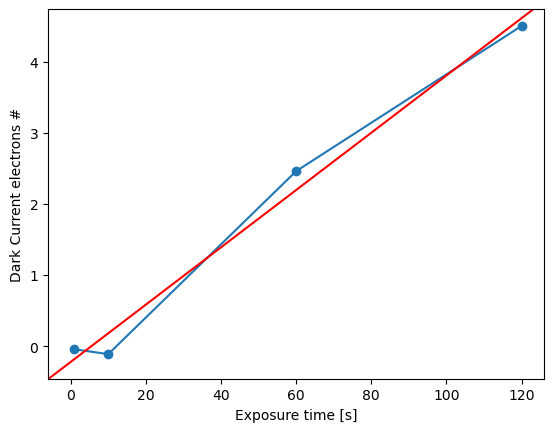

In [38]:
fig, ax = plt.subplots()
ax.plot(list(dark_stacked.keys()),[dark_stacked[i].mean() for i in dark_stacked.keys()],linestyle="-",marker="o")
plt.xlabel("Exposure time [s]")
plt.ylabel("Dark Current electrons #")
ax.axline((0, intercept), slope=slope, color='red', label='by slope')

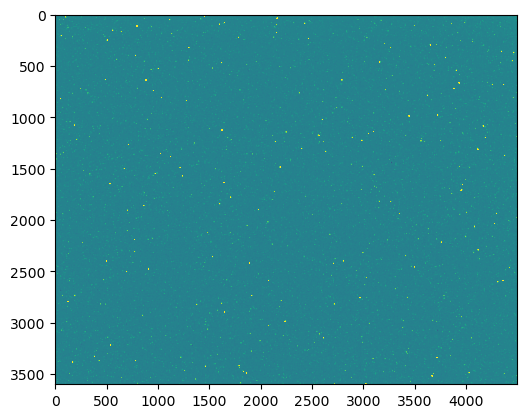

In [39]:
plt.imshow(dark_stacked[60],clim=[-20,30])

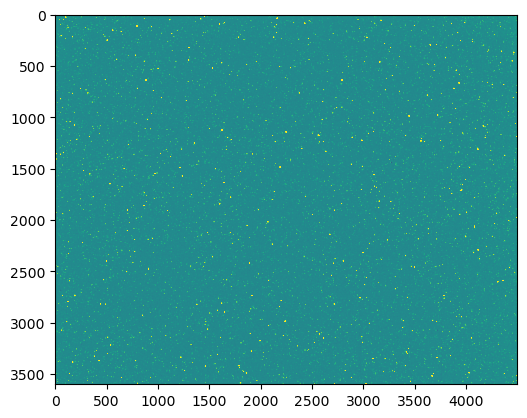

In [40]:

plt.imshow(dark_stacked[120],clim=[-20,30])

## Dark Current Pixelwise

Dark current is calculated per pixel, only the with count higher than the 0.99 quantile are considered (160k instead of 16M as they are reduced by a factor of 100)

In [41]:
limit = np.quantile(dark_stacked[120], 0.99)
limit

15.899999999999999

In [42]:
lista_pixel=[]
if not os.path.exists("currents.npz"):
    currents = np.zeros((3599, 4499))
    c=0
    
    for i in range(currents.shape[0]):
        for j in range(currents.shape[1]):
            if dark_stacked[120][i][j] > limit:
                currents[i][j] = stats.linregress(list(dark_stacked.keys()), [dark_stacked[k][i][j] for k in dark_stacked.keys()])[0]
                lista_pixel.append((i,j))
                c+=1
    print(c)
    np.savez_compressed("currents.npz",currents)
else:
    currents=np.load("currents.npz")['arr_0']

In [43]:
# The dark current calculated on the first 160k brighter pixels is much higher than the one calculated on the whole sensor
currents[currents>0].mean()

0.6615201852293319

In [44]:
#Choose a random pixel, among the most affected, and calculate the dark current for that pixel, than plot it (different results each run)
if lista_pixel:
    pix = random.choice(lista_pixel)
    current,intercept = stats.linregress(list(dark_stacked.keys()), [dark_stacked[k][pix[0]][pix[1]] for k in dark_stacked.keys()])[0:2]
    print(f"Pixel # {pix} has dark current:",current,"e/s")
    fig, ax = plt.subplots()
    ax.plot(list(dark_stacked.keys()),[dark_stacked[k][pix[0]][pix[1]] for k in dark_stacked.keys()],linestyle="-",marker="o")
    plt.xlabel("Exposure time [s]")
    plt.ylabel("Dark Current electrons #")
    ax.axline((0, intercept), slope=current, color='red', label='by slope')

## Dark current subtraction

In [45]:
expodict = {}
for img in processed_images.keys():
    data = fits.open("./dataM103/"+img)
    expodict[img] = data[0].header['EXPTIME']
    data.close()

for img in processed_calibration.keys():
    data = fits.open("./dataM103/"+img)
    expodict[img] = data[0].header['EXPTIME']
    data.close()

In [46]:
processed_images_wo_dark = {}
for k in processed_images.keys():
    processed_images_wo_dark[k] = processed_images[k] - currents * expodict[k]

processed_calibration_wo_dark = {}
for k in processed_calibration.keys():
    processed_calibration_wo_dark[k] = processed_calibration[k] - currents * expodict[k]
    

In [47]:
#After this operation the dictionaries processed_images_wo_dark 
# and processed_calibration_wo_dark contains the images of M103 
# and the images of calibration stars with count in electrions, 
# bias subtracted, flat corrected and dark current removed

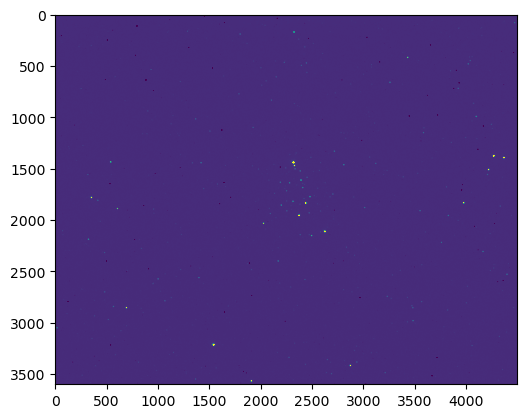

In [48]:
plt.imshow(processed_images_wo_dark['M103_003OIII300s.fit'],clim=[0,1000])

# Sky background

In [49]:
lst_stdskymean = []
lst_stdskylevel = []
lst_stdskyrms = []
for k in processed_images_wo_dark.keys():
    stdskymean, stdskylevel, stdskyrms = (sigma_clipped_stats(processed_images_wo_dark[k], sigma=2, maxiters=20))
    lst_stdskymean.append(stdskymean/expodict[k])
    lst_stdskylevel.append(stdskylevel/expodict[k])
    lst_stdskyrms.append(stdskyrms/expodict[k])

stdskymean = np.array(lst_stdskymean).mean()
stdskylevel = np.array(lst_stdskylevel).mean()
stdskyrms = np.array(lst_stdskyrms).mean()
print(f"Averages e/s of sky background on target images: \nstdskymean: {stdskymean}, stdskylevel: {stdskylevel}, stdskyrms: {stdskyrms}")

Averages e/s of sky background on target images: 
stdskymean: 0.36982755853328325, stdskylevel: 0.3697564582258628, stdskyrms: 0.04085355384633208


In [50]:
lst_stdskymean_calib = []
lst_stdskylevel_calib = []
lst_stdskyrms_calib = []
for k in processed_calibration_wo_dark.keys():
    stdskymean_cal, stdskylevel_cal, stdskyrms_cal = (sigma_clipped_stats(processed_calibration_wo_dark[k], sigma=3, maxiters=20))
    lst_stdskymean_calib.append(stdskymean_cal/expodict[k])
    lst_stdskylevel_calib.append(stdskylevel_cal/expodict[k])
    lst_stdskyrms_calib.append(stdskyrms_cal/expodict[k])
stdskymean_calib = np.array(lst_stdskymean_calib).mean()
stdskylevel_calib = np.array(lst_stdskylevel_calib).mean()
stdskyrms_calib = np.array(lst_stdskyrms_calib).mean()
print(f"Averages e/s of sky background on standard star images: \nstdskymean: {stdskymean_calib}, stdskylevel: {stdskylevel_calib}, stdskyrms: {stdskyrms_calib}")


Averages e/s of sky background on standard star images: 
stdskymean: 0.6353051076709181, stdskylevel: 0.4583836951107299, stdskyrms: 24.156684359248626


As target images were taken at higher exposition time compared to standard star frames, they are used to calculate sky background as sky background/bias (or dark current) ratio is greater

## Correct target images and standard star images by sky background

In [51]:
processed_images_wo_dark_wo_sky = {}
processed_calibration_wo_dark_wo_sky = {}
for k in processed_images_wo_dark.keys():
    processed_images_wo_dark_wo_sky[k] = processed_images_wo_dark[k] - stdskymean*expodict[k]
for k in processed_calibration_wo_dark.keys():
    processed_calibration_wo_dark_wo_sky[k] = processed_calibration_wo_dark[k] - stdskymean*expodict[k]

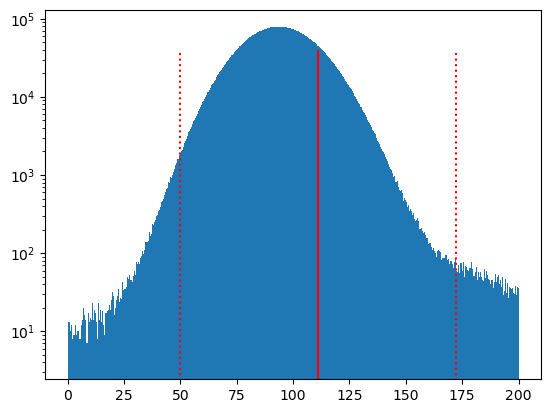

In [52]:
plt.hist(processed_images_wo_dark[list(processed_images_wo_dark.keys())[3]].flatten(),bins=1000,range=[0,200])
plt.vlines(stdskymean*300,ymin = 0,ymax=40000,color='red',label='stdskylevel')
plt.vlines(stdskymean*300+5.*stdskyrms*300,ymin = 0,ymax=40000,linestyles=":",color='red')
plt.vlines(stdskymean*300-5.*stdskyrms*300,ymin = 0,ymax=40000,linestyles=":",color='red')
plt.yscale('log')

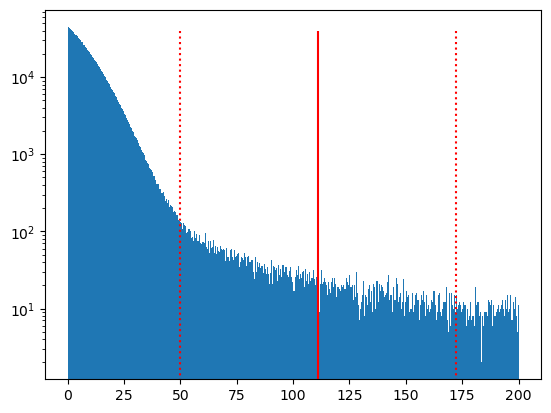

In [53]:
plt.hist(processed_images_wo_dark_wo_sky[list(processed_images_wo_dark.keys())[3]].flatten(),bins=1000,range=[0,200])
plt.vlines(stdskymean*300,ymin = 0,ymax=40000,color='red',label='stdskylevel')
plt.vlines(stdskymean*300+5.*stdskyrms*300,ymin = 0,ymax=40000,linestyles=":",color='red')
plt.vlines(stdskymean*300-5.*stdskyrms*300,ymin = 0,ymax=40000,linestyles=":",color='red')
plt.yscale('log')

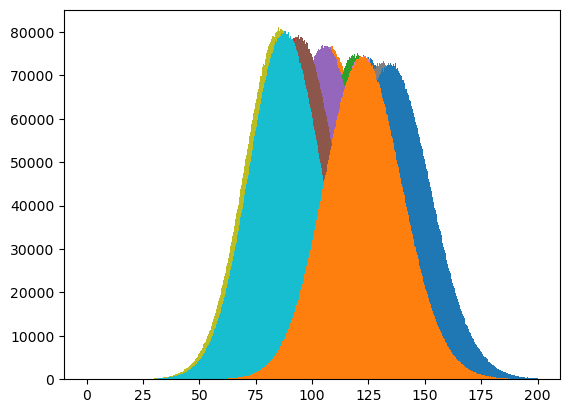

In [54]:
for k in processed_images_wo_dark.keys():
    plt.hist(processed_images_wo_dark[k].flatten(),bins=1000,range=[0,200])

# Standard star

## UniMiB filters creation

In [55]:
#using speclite modulus from https://speclite.readthedocs.io/en/latest/
from speclite import filters

In [56]:
#Code to create .ECSV filters to be used with speclite modulus
reprocess = False
if reprocess:
    Ha_filter_trans = pd.read_csv("./Halpha_3p5nm_Ultra-Narrowband.txt",sep=r"\s+")
    OIII_filter_trans = pd.read_csv("./OIII_4nm_Ultra-Narrowband.txt",sep=r"\s+")
    SII_filter_trans = pd.read_csv("./SII_4nm_Ultra-Narrowband.txt",sep=r"\s+")
    Ha_filter_trans['wave_A']=round(Ha_filter_trans['#Wave_nm']*10,2)
    Ha_filter_trans['T']=round(Ha_filter_trans['Transmission']/100,5)
    OIII_filter_trans['wave_A']=round(OIII_filter_trans['#Wave_nm']*10,2)
    OIII_filter_trans['T']=round(OIII_filter_trans['Transmission']/100,5)
    SII_filter_trans['wave_A']=round(SII_filter_trans['#Wave_nm']*10,2)
    SII_filter_trans['T']=round(SII_filter_trans['Transmission']/100,5)
    Ha_filter_trans.drop(columns=['#Wave_nm','Transmission'],inplace=True)
    OIII_filter_trans.drop(columns=['#Wave_nm','Transmission'],inplace=True)
    SII_filter_trans.drop(columns=['#Wave_nm','Transmission'],inplace=True)
    Ha_filter_trans.to_csv("Ha_filter.ecsv",sep=" ",header=None,index=None)
    OIII_filter_trans.to_csv("OIII_filter_trans.ecsv",sep=" ",header=None,index=None)
    SII_filter_trans.to_csv("SII_filter_trans.ecsv",sep=" ",header=None,index=None)
    #text to prepend to filters to transform txt file into ECSV properly with metadata
    text_to_prepend_Ha = """# %ECSV 1.0
    # ---
    # datatype:
    # - {name: wavelength, unit: Angstrom, datatype: float64}
    # - {name: response, datatype: float64}
    # meta: !!omap
    # - {band_name: Ha}
    # - {group_name: UniMiB}
    wavelength response"""
    text_to_prepend_OIII = """# %ECSV 1.0
    # ---
    # datatype:
    # - {name: wavelength, unit: Angstrom, datatype: float64}
    # - {name: response, datatype: float64}
    # meta: !!omap
    # - {band_name: OIII}
    # - {group_name: UniMiB}
    wavelength response"""
    text_to_prepend_SII = """# %ECSV 1.0
    # ---
    # datatype:
    # - {name: wavelength, unit: Angstrom, datatype: float64}
    # - {name: response, datatype: float64}
    # meta: !!omap
    # - {band_name: SII}
    # - {group_name: UniMiB}
    wavelength response"""
    line_prepender('./Ha_filter.ecsv',text_to_prepend_Ha)
    line_prepender('./OIII_filter_trans.ecsv',text_to_prepend_OIII)
    line_prepender('./SII_filter_trans.ecsv',text_to_prepend_SII)

In [57]:
Bico_filters = filters.load_filters('Ha_filter.ecsv','OIII_filter_trans.ecsv','SII_filter_trans.ecsv')

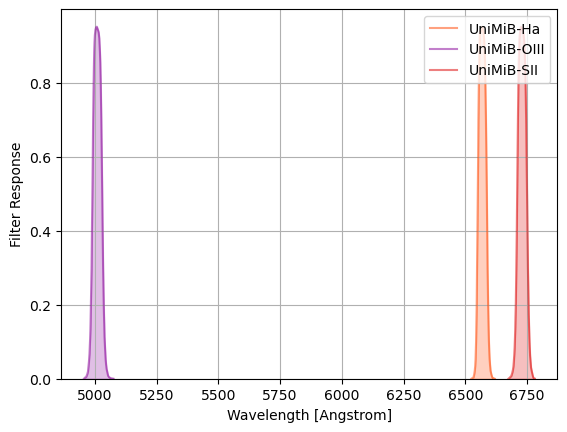

In [58]:
filters.plot_filters(Bico_filters)

In [59]:
Bico_filters.effective_wavelengths

<Quantity [6569.05793053, 5009.15256507, 6730.10447145] Angstrom>

## Standard star magnitude through our filters

In [60]:
HD3360_emissions = pd.read_csv("./fhr153.dat.txt",sep=r"\s+",header=None,names=["wavelength_A","flux_ergs/cm/cm/s/A*10**16","flux_milli_Jy"])
wlen_HD3360 = HD3360_emissions['wavelength_A'].to_numpy() * u.Angstrom 
flux_HD3360 = HD3360_emissions['flux_ergs/cm/cm/s/A*10**16'].to_numpy() * u.erg / (u.cm**2 * u.s * u.Angstrom *10**16)

In [61]:
wlen_HD3360

<Quantity [  925.52  ,   934.78  ,   944.04  , ..., 11969.75  , 11989.7305,
           12009.7402] Angstrom>

In [62]:
flux_HD3360

<Quantity [4.7773e-10, 1.2446e-09, 2.2219e-09, ..., 8.1259e-12, 8.0799e-12,
           8.0340e-12] erg / (Angstrom cm2 s)>

In [63]:
#AB magnitudes convolving HD3360 flux through UniMiB filters
mag_HD3360_unimib = Bico_filters.get_ab_magnitudes(flux_HD3360,wlen_HD3360).as_array()
print(f"HD3360 theoretically shows:\n\
    AB Magnitude {mag_HD3360_unimib['UniMiB-Ha']} through our Ha filter\n\
    AB Magnitude {mag_HD3360_unimib['UniMiB-OIII']} through our OIII filter\n\
    AB Magnitude {mag_HD3360_unimib['UniMiB-SII']} through our SII filter")

HD3360 theoretically shows:
    AB Magnitude [4.02077374] through our Ha filter
    AB Magnitude [3.49282932] through our OIII filter
    AB Magnitude [3.98019712] through our SII filter


## Experimental standard star magnitude

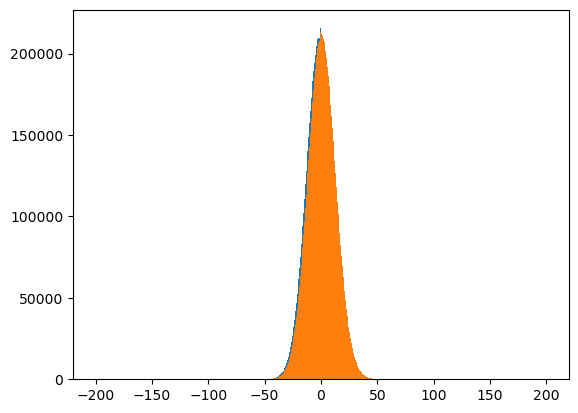

In [64]:
for k in list(processed_calibration_wo_dark_wo_sky.keys())[4:6]:
    plt.hist(processed_calibration_wo_dark_wo_sky[k].flatten(),bins=1000,range=[-200,200])

In [78]:
processed_calibration_wo_dark_wo_sky.keys()

dict_keys(['HD3360_003Ha.fit', 'HD3360_003OIII.fit', 'HD3360_001Ha.fit', 'HD3360_002OIII.fit', 'HD3360_003SII.fit', 'HD3360_002Ha.fit', 'HD3360_001OIII.fit', 'HD3360_001SII.fit', 'HD3360_002SII.fit'])

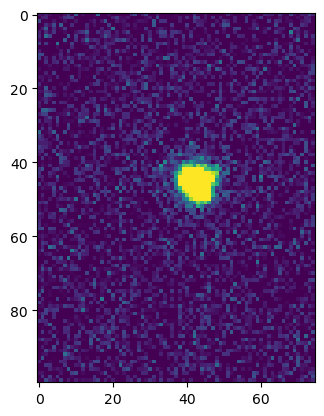

In [142]:

cutoutHa = processed_calibration_wo_dark_wo_sky['HD3360_001Ha.fit'][1685:1785,2275:2350]
cutoutOIII = processed_calibration_wo_dark_wo_sky['HD3360_003OIII.fit'][1685:1785,2275:2350]
cutoutSII = processed_calibration_wo_dark_wo_sky['HD3360_003SII.fit'][1685:1785,2275:2350]
plt.imshow(cutoutHa,clim=[0,100])

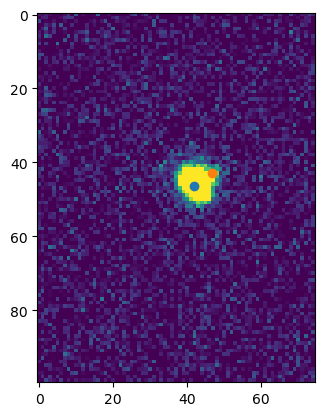

In [143]:
plt.clf()
plt.imshow(cutoutHa,clim=[0,100])
xc1Ha,yc1Ha = photutils.centroids.centroid_com(cutoutHa)
xc2Ha,yc2Ha = photutils.centroids.centroid_2dg(cutoutHa)
xc1OIII,yc1OIII = photutils.centroids.centroid_com(cutoutOIII)
xc2OIII,yc2OIII = photutils.centroids.centroid_2dg(cutoutOIII)
xc1SII,yc1SII = photutils.centroids.centroid_com(cutoutSII)
xc2SII,yc2SII = photutils.centroids.centroid_2dg(cutoutSII)
plt.scatter([xc1Ha],[yc1Ha])
plt.scatter([xc2Ha],[yc2Ha])

FWHM  1.881177417320412


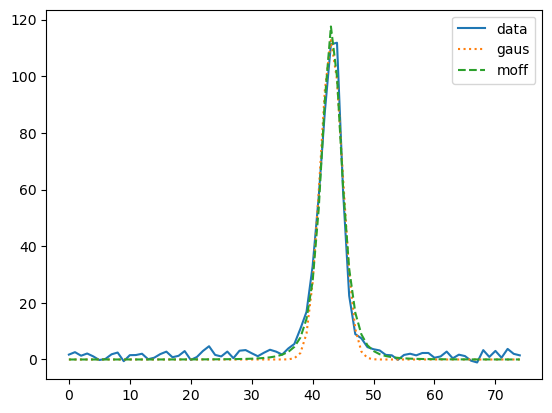

In [144]:
xplane = np.nanmean(cutoutHa,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=40, stddev=4)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

moff = models.Moffat1D(amplitude=20,x_0=40, gamma=1, alpha=1)
xaxis = np.arange(len(xplane))
moffit = fit_g(moff, xaxis, xplane)
plt.plot(xaxis,moffit(xaxis),linestyle="--",label='moff')
plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM ",2.355*gausfit.stddev*pixtoasc)


In [145]:
2.355*gausfit.stddev*3

12.826209663548264

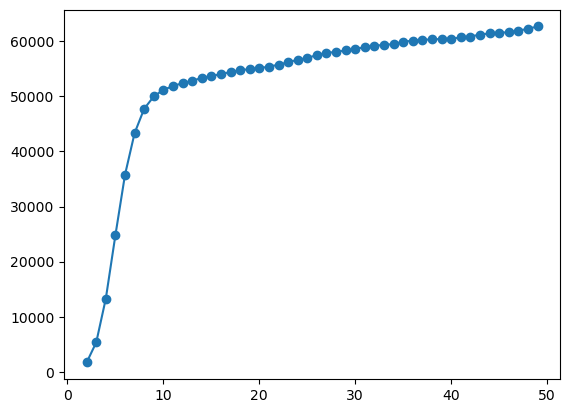

In [146]:
positions = [(xc2Ha,yc2Ha)]
radii = np.arange(2,50,1)
phot = np.zeros(len(radii))

for ii,rr in enumerate(radii):
    aper = photutils.CircularAperture(positions, r=rr)
    phot_table = photutils.aperture_photometry(cutoutHa, aper)
    phot[ii] = phot_table['aperture_sum']
plt.clf()
plt.scatter(radii,phot)
plt.plot(radii,phot)


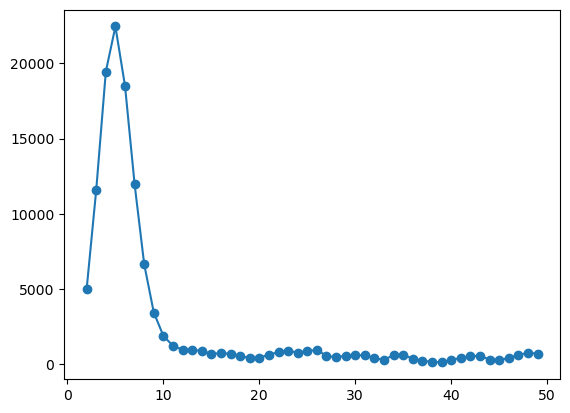

In [147]:
for ii,rr in enumerate(radii):
    aperring = photutils.aperture.CircularAnnulus(positions, rr-1, rr+1)
    #aper = photutils.CircularAperture(positions, r=rr)
    phot_table = photutils.aperture_photometry(cutoutHa, aperring)
    phot[ii] = phot_table['aperture_sum']
plt.clf()
plt.scatter(radii,phot)
plt.plot(radii,phot)


In [148]:
positions

[(46.63293517716383, 42.81251683485152)]

In [149]:
cum_lum=[]
for f in [(xc2Ha,yc2Ha,cutoutHa),(xc2OIII,yc2OIII,cutoutOIII),(xc2SII,yc2SII,cutoutSII)]:
    positions = [f[0],f[1]]
    apermax = photutils.CircularAperture(positions, r=40)
    cum_lum.append(photutils.aperture_photometry(f[2], apermax)['aperture_sum'])
print(cum_lum)

[<Column name='aperture_sum' dtype='float64' length=1>
60413.745346965756, <Column name='aperture_sum' dtype='float64' length=1>
113116.13620018323, <Column name='aperture_sum' dtype='float64' length=1>
63744.337666795895]


In [150]:
f_freq_stand_Ha=3631*10**(-23)*10**(-mag_HD3360_unimib['UniMiB-Ha']/2.5)
f_freq_stand_OIII=3631*10**(-23)*10**(-mag_HD3360_unimib['UniMiB-OIII']/2.5)
f_freq_stand_SII=3631*10**(-23)*10**(-mag_HD3360_unimib['UniMiB-SII']/2.5)
f_lambda_stand_Ha = f_freq_stand_Ha*C/lamb**2
f_lambda_stand_OIII = f_freq_stand_OIII*C/lamb**2
f_lambda_stand_SII = f_freq_stand_SII*C/lamb**2
print(f"zero point for Ha is: {math.log10(cum_lum[0]/f_lambda_stand_Ha)}\n\
zero point for OIII is: {math.log10(cum_lum[1]/f_lambda_stand_OIII)}\n\
zero point for SII is: {math.log10(cum_lum[2]/f_lambda_stand_SII)}\n\
log10([e/s]/[erg/s/cm^2/A])")

zero point for Ha is: 14.833323682901074
zero point for OIII is: 14.894534716817153
zero point for SII is: 14.840398888497683
log10([e/s]/[erg/s/cm^2/A])


## Local background subtraction

In [152]:
bkg_mean=[]
for f in [(xc2Ha,yc2Ha,cutoutHa),(xc2OIII,yc2OIII,cutoutOIII),(xc2SII,yc2SII,cutoutSII)]:
    positions = [f[0],f[1]]
    annulus_aperture = photutils.aperture.CircularAnnulus(positions, r_in=40, r_out=60)
    aperstats = photutils.aperture.ApertureStats(f[2], annulus_aperture)
    bkg_mean.append(aperstats.mean)
print(bkg_mean)  

[1.3533967303882513, -0.23446686934922, -0.6947844664347371]


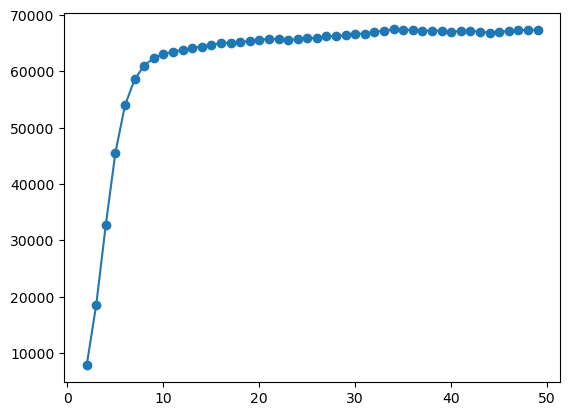

In [162]:
cutout_wo_localBK_Ha = cutoutHa - bkg_mean[0]
cutout_wo_localBK_OIII = cutoutOIII - bkg_mean[1]
cutout_wo_localBK_SII = cutoutSII - bkg_mean[2]
new_cumulative_lum = []
for f in [(xc2Ha,yc2Ha,cutout_wo_localBK_Ha),(xc2OIII,yc2OIII,cutout_wo_localBK_OIII),(xc2SII,yc2SII,cutout_wo_localBK_SII)]:
    for ii,rr in enumerate(radii):
        aper = photutils.CircularAperture((f[0],f[1]), r=rr)
        phot_table = photutils.aperture_photometry(f[2], aper)
        phot[ii] = phot_table['aperture_sum']
    new_cumulative_lum.append(phot_table['aperture_sum'])
    plt.clf()
    plt.scatter(radii,phot)
    plt.plot(radii,phot)



In [163]:
print(new_cumulative_lum)

[<Column name='aperture_sum' dtype='float64' length=1>
54338.532574004465, <Column name='aperture_sum' dtype='float64' length=1>
114142.80424473772, <Column name='aperture_sum' dtype='float64' length=1>
67400.92437807485]


In [164]:
new_cumulative_lum

print(f"Zero points with local background subtracted:\nzero point for Ha is: {math.log10(new_cumulative_lum[0]/f_lambda_stand_Ha)}\n\
zero point for OIII is: {math.log10(new_cumulative_lum[1]/f_lambda_stand_OIII)}\n\
zero point for SII is: {math.log10(new_cumulative_lum[2]/f_lambda_stand_SII)}\n\
log10([e/s]/[erg/s/cm^2/A])")

Zero points with local background subtracted:
zero point for Ha is: 14.787295828279895
zero point for OIII is: 14.898458692691825
zero point for SII is: 14.864623128297307
log10([e/s]/[erg/s/cm^2/A])


# Frames aligning and stacking

In [171]:
processed_images_wo_dark_wo_sky.keys()


dict_keys(['M103_003OIII300s.fit', 'M103_003Ha300s.fit', 'M103_002Ha300s.fit', 'M103_002SII300s.fit', 'M103_004Ha300s.fit', 'M103_001SII300s.fit', 'M103_001Ha300s.fit', 'M103_002OIII300s.fit', 'M103_004SII300s.fit', 'M103_003SII300s.fit', 'M103_001OIII300s.fit', 'M103_004OIII300s.fit'])

In [172]:
registered_image, footprint = asa.register(processed_images_wo_dark_wo_sky['M103_003Ha300s.fit'], processed_images_wo_dark_wo_sky['M103_002Ha300s.fit'])

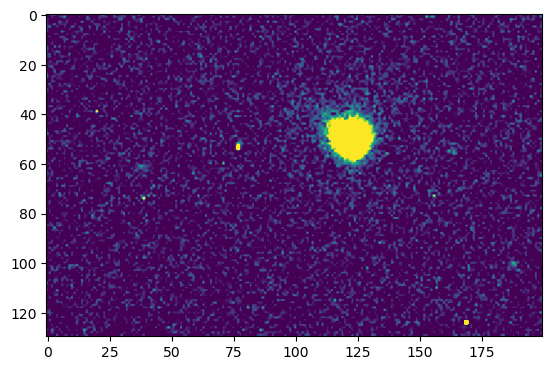

In [217]:
img1=processed_images_wo_dark_wo_sky['M103_003Ha300s.fit'][120:250,2200:2400]
img2=processed_images_wo_dark_wo_sky['M103_002Ha300s.fit'][120:250,2200:2400]
img3=registered_image[120:250,2200:2400]
plt.clf()
plt.imshow(img1,clim=[0,100])



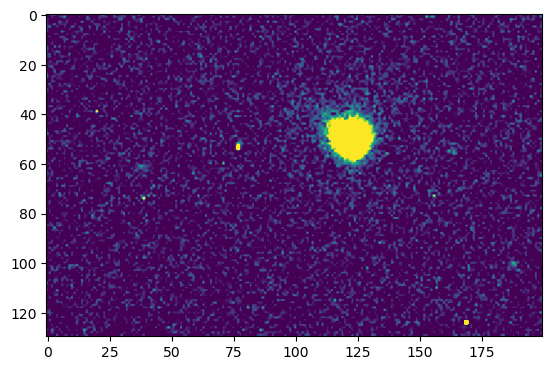

In [218]:
plt.clf()
plt.imshow(img1,clim=[0,100])

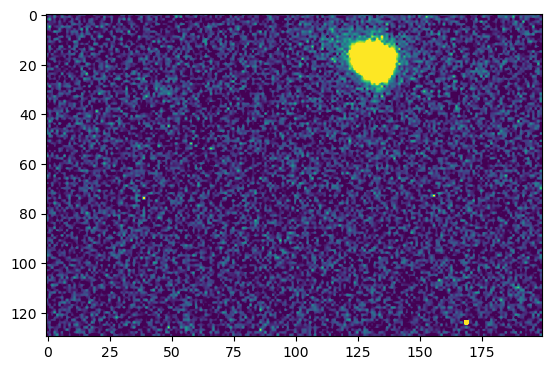

In [219]:
plt.clf()
plt.imshow(img2,clim=[0,100])

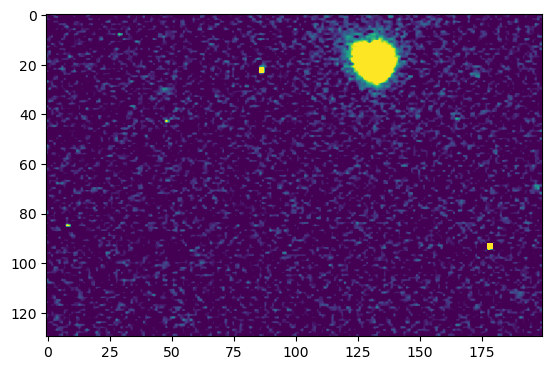

In [220]:
plt.clf()
plt.imshow(img3,clim=[0,100])